In [2]:
import os
import string
import pickle
import re, nltk
from tqdm import *
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
from wordcloud import WordCloud
from nltk.tag import pos_tag
from nltk.collocations import *
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score
import pyLDAvis
import pyLDAvis.sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\ACER\anaconda3\envs\nlp\lib\site-packages\scikitplot\plotters.py:37: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  DeprecationWarning)


In [3]:
# Load dataset
text = ''
with open('Data/News/News Set B.txt','r', encoding='utf-8') as f:
    text = " ".join([l.strip() for l in f.readlines()])

In [4]:
# Preview snippet of text
text[0:500]

'URL: http://www.nytimes.com/2016/06/30/sports/baseball/washington-nationals-max-scherzer-baffles-mets-completing-a-sweep.html  WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their offensive woes. But they cannot produce an encore of their pennant-winning season if their lineup keeps floundering while their pitching is nicked, bruised and stretched thin. “We were going to ride our pitching,” Manager Terry Collins said before Wednesday’s game. “But we’r'

In [5]:
# Remove URLs
p = re.compile('URL:\shttp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|\
                [!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-20e2ddc4b282>:3: DeprecationWarning: invalid escape sequence \s
  [!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')


In [6]:
articles = p.split(text)

In [7]:
for i, line in enumerate(articles): articles[i] = line.strip()

In [8]:
# Display a sample article after initial clean-up
print(articles[1])

WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their offensive woes. But they cannot produce an encore of their pennant-winning season if their lineup keeps floundering while their pitching is nicked, bruised and stretched thin. “We were going to ride our pitching,” Manager Terry Collins said before Wednesday’s game. “But we’re not riding it right now. We’ve got as many problems with our pitching as we do anything.” Wednesday’s 4-2 loss to the Washington Nationals was cruel for the already-limping Mets. Pitching in Steven Matz’s place, the spot starter Logan Verrett allowed two runs over five innings. But even that was too large a deficit for the Mets’ lineup to overcome against Max Scherzer, the Nationals’ starter. “We’re not even giving ourselves chances,” Collins said, adding later, “We just can’t give our pitchers any room to work.” The Mets did not score until the ninth inning, when a last-gasp two-run homer by James Loney off Nationals

In [9]:
# Load data into a dataframe for further analysis
df = DataFrame(articles,columns=['content'])
df.head()

,content
0,
1,WASHINGTON — Stellar pitching kept the Mets af...
2,Mayor Bill de Blasio’s counsel and chief legal...
3,In the early morning hours of Labor Day last y...
4,It was the Apple Store in New York City before...


In [10]:
# Display total number of news articles before cleaning
len(df)

8889

In [11]:
# Assign nan value to cells with empty fields
nan_value = float("NaN")

# Convert NaN values to empty string
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["content"], inplace=True)
df.head()

,content
1,WASHINGTON — Stellar pitching kept the Mets af...
2,Mayor Bill de Blasio’s counsel and chief legal...
3,In the early morning hours of Labor Day last y...
4,It was the Apple Store in New York City before...
5,OMAHA — The United States Olympic swimming tri...


In [12]:
# Display total number of news articles after removing empty rows
len(df)

8884

In [13]:
# Replace words containing numbers with a single space and convert words to lowercase
lower_alpha = lambda x: re.sub(r"""\w*\d\w*""", ' ', x.lower())

df['content'] = df.content.map(lower_alpha)
df.head()

,content
1,washington — stellar pitching kept the mets af...
2,mayor bill de blasio’s counsel and chief legal...
3,in the early morning hours of labor day last y...
4,it was the apple store in new york city before...
5,omaha — the united states olympic swimming tri...


In [14]:
# Remove all punctuations
punc_re = lambda x: re.sub(r"""[\.,—“”’:;#$?%!&()_'`*""˜{|}~]""", ' ', x)

df['content'] = df.content.map(punc_re)
df.head()

,content
1,washington stellar pitching kept the mets af...
2,mayor bill de blasio s counsel and chief legal...
3,in the early morning hours of labor day last y...
4,it was the apple store in new york city before...
5,omaha the united states olympic swimming tri...


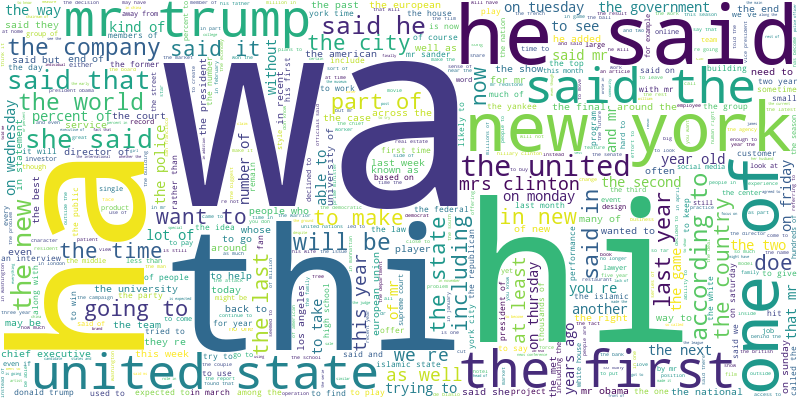

In [15]:
# Join the different processed titles together
long_string = ','.join(list(df['content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, width=800, height=400, 
                      contour_width=20, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Tokenize the reviews into words and insert the list of tokens into a new column 'tokens'
df['tokens'] = df.content.map(word_tokenize)
df.head()

,content,tokens
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming..."


In [17]:
# Remove stop words
stop_words = stopwords.words('english')

# To include these words as stop words after insights from the initial run of code
new_stopwords = ['said','say','mr']
stop_words.extend(new_stopwords)

stop_lambda = lambda x: [y for y in x if y not in stop_words]

df['tokens_stop'] = df.tokens.apply(stop_lambda)
df.head()

,content,tokens,tokens_stop
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri..."


In [18]:
# Perform  basic lemmatization
lemmatizer = WordNetLemmatizer()
lemmatizer_lambda = lambda x: [lemmatizer.lemmatize(y) for y in x]

df['tokens_lemma_simple'] = df.tokens_stop.apply(lemmatizer_lambda)
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria..."


In [19]:
# Perform lemmitization considering parts of speech tagging
pos_lambda = lambda x: nltk.pos_tag(x)

df['tokens_pos'] = (df.tokens_stop.apply(pos_lambda))
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af...","[(washington, NN), (stellar, NN), (pitching, N..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega...","[(mayor, NN), (bill, NN), (de, IN), (blasio, F..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,...","[(early, RB), (morning, NN), (hours, NNS), (la..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ...","[(apple, NN), (store, NN), (new, JJ), (york, N..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria...","[(omaha, RB), (united, JJ), (states, NNS), (ol..."


In [20]:
# Convert the naming scheme to one that is recognized by WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"

In [21]:
# Perform lemmitization using wordnet
lemmatizer = WordNetLemmatizer()
lemmatizer_fun = lambda x: lemmatizer.lemmatize(*x)

df['tokens_lemma_with_pos'] = df.tokens_pos\
                        .apply(lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x])\
                        .apply(lambda x: [lemmatizer_fun(y) for y in x])
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos,tokens_lemma_with_pos
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af...","[(washington, NN), (stellar, NN), (pitching, N...","[washington, stellar, pitching, keep, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega...","[(mayor, NN), (bill, NN), (de, IN), (blasio, F...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,...","[(early, RB), (morning, NN), (hours, NNS), (la...","[early, morning, hour, labor, day, last, year,..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ...","[(apple, NN), (store, NN), (new, JJ), (york, N...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria...","[(omaha, RB), (united, JJ), (states, NNS), (ol...","[omaha, united, state, olympic, swim, trial, s..."


In [23]:
# Convert data type of dataframe to string
df = df.astype(str)

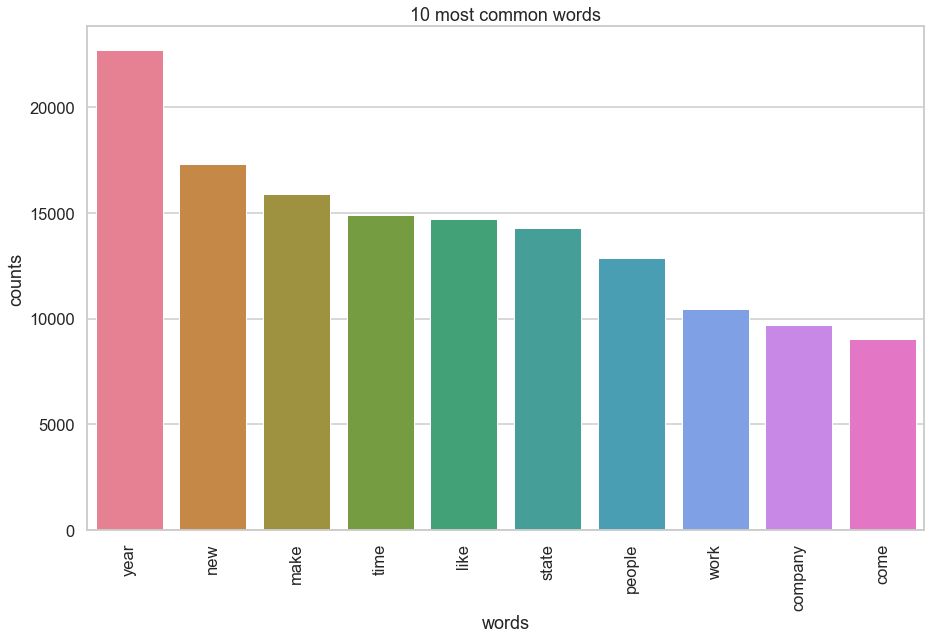

In [24]:
sns.set_style('whitegrid')

# Function to plot the top 10 common words
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['tokens_lemma_with_pos'])

# Visualize the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [26]:
# Function to display topics and sort the terms
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
# Decide on the number of features
no_features = 1000

# Initialise the count vectorizer with the English stop words
tf_vectorizer = CountVectorizer(max_features=no_features, stop_words='english')

# Fit and transform the processed content
tf_vectorized_documents = tf_vectorizer.fit_transform(df['tokens_lemma_with_pos'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [28]:
# Set boundaries for minimum and maximum number of topics
kmin=15
kmax=25

In [29]:
topic_models = []

for k in tqdm(range(kmin,kmax+1)):
    print("Applying and scoring LDA for k=%d ..." % k )
    
    lda_model = LatentDirichletAllocation(n_components= k, max_iter=5, 
                                          learning_method='online', learning_offset=50.,
                                          random_state=8)
    
    lda_output = lda_model.fit_transform(tf_vectorized_documents)  
    log_likelihood = lda_model.score(tf_vectorized_documents)
    perplexity = lda_model.perplexity(tf_vectorized_documents)
    topic_models.append((k,lda_model,lda_output, log_likelihood, perplexity)) 

  0%|          | 0/11 [00:00<?, ?it/s]

Applying and scoring LDA for k=15 ...


  9%|▉         | 1/11 [01:59<19:59, 119.97s/it]

Applying and scoring LDA for k=16 ...


 18%|█▊        | 2/11 [04:01<18:03, 120.36s/it]

Applying and scoring LDA for k=17 ...


 27%|██▋       | 3/11 [06:06<16:15, 121.96s/it]

Applying and scoring LDA for k=18 ...


 36%|███▋      | 4/11 [08:14<14:25, 123.64s/it]

Applying and scoring LDA for k=19 ...


 45%|████▌     | 5/11 [10:26<12:37, 126.24s/it]

Applying and scoring LDA for k=20 ...


 55%|█████▍    | 6/11 [12:36<10:36, 127.37s/it]

Applying and scoring LDA for k=21 ...


 64%|██████▎   | 7/11 [15:05<08:54, 133.69s/it]

Applying and scoring LDA for k=22 ...


 73%|███████▎  | 8/11 [17:45<07:04, 141.64s/it]

Applying and scoring LDA for k=23 ...


 82%|████████▏ | 9/11 [20:11<04:45, 142.88s/it]

Applying and scoring LDA for k=24 ...


 91%|█████████ | 10/11 [22:32<02:22, 142.45s/it]

Applying and scoring LDA for k=25 ...


100%|██████████| 11/11 [24:56<00:00, 136.06s/it]


In [30]:
# Print the number of topics with its corresponding perplexity and log likelihood
for model in topic_models:
    print("k topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f" %(model[0], model[3], model[4]))  

k topics :  15, Log Likelihood : -11837989.92   Perplexity : 534.98
k topics :  16, Log Likelihood : -11832079.03   Perplexity : 533.30
k topics :  17, Log Likelihood : -11824727.05   Perplexity : 531.22
k topics :  18, Log Likelihood : -11821928.54   Perplexity : 530.44
k topics :  19, Log Likelihood : -11810281.03   Perplexity : 527.17
k topics :  20, Log Likelihood : -11810193.46   Perplexity : 527.14
k topics :  21, Log Likelihood : -11802686.63   Perplexity : 525.05
k topics :  22, Log Likelihood : -11807245.27   Perplexity : 526.32
k topics :  23, Log Likelihood : -11817859.43   Perplexity : 529.29
k topics :  24, Log Likelihood : -11789824.68   Perplexity : 521.48
k topics :  25, Log Likelihood : -11790325.69   Perplexity : 521.61


In [35]:
best_k = 24
best_lda_model = topic_models[best_k - kmin][1]
no_top_words = 15
display_topics(best_lda_model, tf_feature_names, no_top_words)

Topic 0:
million pay year company money sale sell employee accord cost include week time ticket buy
Topic 1:
trump china chinese donald campaign republican speech make country presidential ad american attack party say
Topic 2:
campaign president clinton obama house republican committee senate senator state political mrs make washington time
Topic 3:
dr health drug study patient medical year test care doctor hospital use cancer woman research
Topic 4:
clinton trump republican voter sander party state election vote campaign candidate primary democratic delegate cruz
Topic 5:
police officer city people official arrest kill report department year man shoot authority death mayor
Topic 6:
european union party britain europe country vote british political leave government minister leader london member
Topic 7:
like people time know year think want make life woman tell come work family thing
Topic 8:
percent bank market company year price billion financial stock investor oil rise rate fund inv

In [44]:
# Plot the pyLDAvis visualizer with the above input
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf_vectorized_documents, tf_vectorizer)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.107397 -0.025868       1        1  13.722241
18    -0.127201  0.028522       2        1   7.568677
19    -0.148151 -0.045552       3        1   7.158309
11     0.039808 -0.071141       4        1   5.479047
8      0.061844  0.111038       5        1   4.726783
10     0.024975  0.060275       6        1   4.656341
16    -0.139315 -0.067648       7        1   4.614162
17     0.044138 -0.026365       8        1   4.585348
15    -0.087531  0.188771       9        1   4.234468
14     0.147708 -0.029756      10        1   4.022309
5     -0.006893  0.020153      11        1   3.771547
12    -0.208698  0.058026      12        1   3.702710
6      0.037086 -0.089522      13        1   3.666532
3     -0.007795  0.024216      14        1   3.609954
4      0.006328 -0.184574      15        1   3.602262
0      0.070093  0.121881      16        1   3.571061
2      0.102482 -0.130909      17        1   3.501766
23     0.000831  0.067248      18        1   2.760830
20     0.066689  0.173971      19        1   2.579852
13     0.111842 -0.123748      20        1   2.563100
1      0.029606 -0.158121      21        1   1.824584
9     -0.180305 -0.000448      22        1   1.509515
22     0.008984 -0.015205      23        1   1.355386
21     0.260872  0.114756      24        1   1.213216, topic_info=         Term          Freq         Total Category  logprob  loglift
928     trump   8353.000000   8353.000000  Default  30.0000  30.0000
178   company   9799.000000   9799.000000  Default  29.0000  29.0000
785    school   5351.000000   5351.000000  Default  28.0000  28.0000
377      game   7705.000000   7705.000000  Default  27.0000  27.0000
591       new  17459.000000  17459.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
532      make    228.281344  15855.634088  Topic24  -4.6066   0.1712
709  question    145.240854   3365.258542  Topic24  -5.0588   1.2690
997      year    172.607150  22800.958036  Topic24  -4.8862  -0.4716
469     issue    135.997427   3487.624227  Topic24  -5.1246   1.1676
442   include    137.157969   8309.487997  Topic24  -5.1161   0.3079

[1070 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.280939  accept
2         2  0.007492  accept
2         3  0.021226  accept
2         4  0.033713  accept
2         5  0.031215  accept
...     ...       ...     ...
999      19  0.015521   young
999      20  0.006209   young
999      21  0.000310   young
999      22  0.003104   young
999      23  0.001863   young

[9824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 19, 20, 12, 9, 11, 17, 18, 16, 15, 6, 13, 7, 4, 5, 1, 3, 24, 21, 14, 2, 10, 23, 22])

In [45]:
topicnames = ["Topic " + str(i) for i in range(best_lda_model.n_components)]
print (topicnames)

['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23']


In [47]:
# Create document names out of the index 
docnames = ["Doc" + str(i) for i in range(len(df['tokens_lemma_with_pos']))]

# Create dataframe by fitting the best LDA output to document-topic matrix
best_lda_output = best_lda_model.fit_transform(tf_vectorized_documents)
df_document_topic = pd.DataFrame(np.round(best_lda_output, 2), columns=topicnames, index=docnames)

# Obtain dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [48]:
# Styling 
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 900 if val > .2 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [49]:
# Create copy of dataframe, apply style to all documents and display first 20 documents
df_document_topic2 = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topic2

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19
Doc1,0.000000,0.000000,0.260000,0.000000,0.000000,0.330000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.110000,0.000000,0.010000,5
Doc2,0.000000,0.000000,0.010000,0.000000,0.000000,0.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,5
Doc3,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.090000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,16
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16
Doc6,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.070000,0.000000,0.070000,0.350000,0.000000,22
Doc7,0.000000,0.000000,0.000000,0.040000,0.000000,0.140000,0.000000,0.210000,0.000000,0.000000,0.000000,0.000000,0.130000,0.160000,0.000000,0.160000,0.000000,0.000000,0.110000,0.000000,0.040000,0.000000,0.000000,0.000000,7
Doc8,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,0.000000,0.000000,0.040000,0.020000,0.000000,0.000000,0.010000,0.000000,0.020000,0.610000,0.040000,0.000000,0.000000,0.000000,19
Doc9,0.000000,0.000000,0.000000,0.000000,0.430000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.180000,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,4


In [51]:
print (f"contents of doc19 is : {df['tokens_lemma_with_pos'][19]}")

contents of doc19 is : ['washington', 'lusty', 'applause', 'greet', 'return', 'capitol', 'behind', 'peck', 'cheek', 'receive', 'sat', 'desk', 'senate', 'floor', 'look', 'vaguely', 'glum', 'receive', 'good', 'wish', 'like', 'warrior', 'return', 'civilization', 'injure', 'intact', 'senator', 'bernie', 'sander', 'vermont', 'back', 'give', 'floor', 'speech', 'deride', 'rich', 'defend', 'misery', 'write', 'op-ed', 'piece', 'trade', 'give', 'television', 'interview', 'decline', 'fully', 'support', 'hillary', 'clinton', 'president', 'spend', 'much', 'wednesday', 'vigorously', 'denounce', 'rescue', 'bill', 'puerto', 'rico', 'support', 'two-thirds', 'fellow', 'senator', 'let', 'u', 'clear', 'sander', 'senate', 'floor', 'wednesday', 'revive', 'familiar', 'brooklyn-inflected', 'pedagogy', 'issue', 'significant', 'part', 'entire', 'debate', 'regard', 'puerto', 'rico', 'billionaire', 'hedge', 'fund', 'manager', 'purchase', 'puerto', 'rican', 'bond', 'penny', 'dollar', 'want', 'percent', 'return', '

In [52]:
# Display first 5 rows in dataframe
df_document_topic.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,dominant_topic
Doc0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,...,0.00,0.00,0.0,0.00,1.0,0.00,0.00,0.0,0.00,19
Doc1,0.0,0.0,0.26,0.0,0.0,0.33,0.0,0.00,0.0,0.00,...,0.00,0.00,0.0,0.00,0.0,0.02,0.11,0.0,0.01,5
Doc2,0.0,0.0,0.01,0.0,0.0,0.68,0.0,0.00,0.0,0.00,...,0.15,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.01,5
Doc3,0.2,0.0,0.00,0.0,0.0,0.00,0.0,0.14,0.0,0.00,...,0.28,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,10
Doc4,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.09,0.0,0.05,...,0.00,0.81,0.0,0.00,0.0,0.00,0.00,0.0,0.04,16


In [53]:
df_label = {0:'finance', 1:'us_domestic', 2:'us_domestic', 3:'health', 4:'us_domestic', 5:'us_domestic', 6:'world', 7:'lifestyle', 
            8:'finance', 9:'world', 10:'technology', 11:'world', 12:'travel', 13:'us_domestic', 14:'us_domestic', 15:'real_estate', 
            16:'sports', 17:'us_domestic', 18:'arts', 19:'sports', 20:'real_estate', 21:'us_domestic', 22:'finance', 23:'education'}

df_document_topic.replace({'dominant_topic': df_label}, inplace=True)
df_document_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,dominant_topic
Doc0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.00,1.00,0.00,0.00,0.0,0.00,sports
Doc1,0.00,0.0,0.26,0.0,0.00,0.33,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.00,0.00,0.02,0.11,0.0,0.01,us_domestic
Doc2,0.00,0.0,0.01,0.0,0.00,0.68,0.00,0.00,0.0,0.00,...,0.15,0.00,0.0,0.02,0.00,0.00,0.00,0.0,0.01,us_domestic
Doc3,0.20,0.0,0.00,0.0,0.00,0.00,0.00,0.14,0.0,0.00,...,0.28,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,technology
Doc4,0.00,0.0,0.00,0.0,0.00,0.01,0.00,0.09,0.0,0.05,...,0.00,0.81,0.0,0.00,0.00,0.00,0.00,0.0,0.04,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc8879,0.00,0.0,0.23,0.0,0.69,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.0,0.00,us_domestic
Doc8880,0.09,0.0,0.00,0.0,0.00,0.54,0.00,0.21,0.0,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,us_domestic
Doc8881,0.07,0.0,0.00,0.0,0.00,0.00,0.11,0.15,0.0,0.04,...,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.0,0.06,travel
Doc8882,0.00,0.0,0.00,0.0,0.00,0.27,0.00,0.53,0.0,0.00,...,0.00,0.00,0.0,0.18,0.00,0.00,0.00,0.0,0.00,lifestyle


In [54]:
# Extract topic labels to list
topic_labels = df_document_topic['dominant_topic'].tolist()

In [55]:
# Add column with topic labels to dataframe with cleaned data for 'content'
df['topic labels'] = topic_labels
df

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos,tokens_lemma_with_pos,topic labels
1,washington stellar pitching kept the mets af...,"['washington', 'stellar', 'pitching', 'kept', ...","['washington', 'stellar', 'pitching', 'kept', ...","['washington', 'stellar', 'pitching', 'kept', ...","[('washington', 'NN'), ('stellar', 'NN'), ('pi...","['washington', 'stellar', 'pitching', 'keep', ...",sports
2,mayor bill de blasio s counsel and chief legal...,"['mayor', 'bill', 'de', 'blasio', 's', 'counse...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...","[('mayor', 'NN'), ('bill', 'NN'), ('de', 'IN')...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...",us_domestic
3,in the early morning hours of labor day last y...,"['in', 'the', 'early', 'morning', 'hours', 'of...","['early', 'morning', 'hours', 'labor', 'day', ...","['early', 'morning', 'hour', 'labor', 'day', '...","[('early', 'RB'), ('morning', 'NN'), ('hours',...","['early', 'morning', 'hour', 'labor', 'day', '...",us_domestic
4,it was the apple store in new york city before...,"['it', 'was', 'the', 'apple', 'store', 'in', '...","['apple', 'store', 'new', 'york', 'city', 'thi...","['apple', 'store', 'new', 'york', 'city', 'thi...","[('apple', 'NN'), ('store', 'NN'), ('new', 'JJ...","['apple', 'store', 'new', 'york', 'city', 'thi...",technology
5,omaha the united states olympic swimming tri...,"['omaha', 'the', 'united', 'states', 'olympic'...","['omaha', 'united', 'states', 'olympic', 'swim...","['omaha', 'united', 'state', 'olympic', 'swimm...","[('omaha', 'RB'), ('united', 'JJ'), ('states',...","['omaha', 'united', 'state', 'olympic', 'swim'...",sports
...,...,...,...,...,...,...,...
8884,there is a second critical contest in america ...,"['there', 'is', 'a', 'second', 'critical', 'co...","['second', 'critical', 'contest', 'america', '...","['second', 'critical', 'contest', 'america', '...","[('second', 'JJ'), ('critical', 'JJ'), ('conte...","['second', 'critical', 'contest', 'america', '...",us_domestic
8885,on april police officers from the precinc...,"['on', 'april', 'police', 'officers', 'from', ...","['april', 'police', 'officers', 'precinct', 'c...","['april', 'police', 'officer', 'precinct', 'ca...","[('april', 'JJ'), ('police', 'NN'), ('officers...","['april', 'police', 'officer', 'precinct', 'ca...",us_domestic
8886,khilad india the cattle camp on a dusty ba...,"['khilad', 'india', 'the', 'cattle', 'camp', '...","['khilad', 'india', 'cattle', 'camp', 'dusty',...","['khilad', 'india', 'cattle', 'camp', 'dusty',...","[('khilad', 'NNS'), ('india', 'VBP'), ('cattle...","['khilad', 'india', 'cattle', 'camp', 'dusty',...",travel
8887,the director j j abrams dropped a possible hi...,"['the', 'director', 'j', 'j', 'abrams', 'dropp...","['director', 'j', 'j', 'abrams', 'dropped', 'p...","['director', 'j', 'j', 'abrams', 'dropped', 'p...","[('director', 'NN'), ('j', 'NN'), ('j', 'NN'),...","['director', 'j', 'j', 'abrams', 'drop', 'poss...",lifestyle


In [56]:
# Create new dataframe with required columns for training
df_clean = df.filter(['content'], axis=1)
df_clean['topic_labels'] = topic_labels
df_clean

,content,topic_labels
1,washington stellar pitching kept the mets af...,sports
2,mayor bill de blasio s counsel and chief legal...,us_domestic
3,in the early morning hours of labor day last y...,us_domestic
4,it was the apple store in new york city before...,technology
5,omaha the united states olympic swimming tri...,sports
...,...,...
8884,there is a second critical contest in america ...,us_domestic
8885,on april police officers from the precinc...,us_domestic
8886,khilad india the cattle camp on a dusty ba...,travel
8887,the director j j abrams dropped a possible hi...,lifestyle


In [57]:
# Split the data into input texts and output labels
X = df_clean.content 
y = df_clean.topic_labels 

In [58]:
X.head()

1    washington   stellar pitching kept the mets af...
2    mayor bill de blasio s counsel and chief legal...
3    in the early morning hours of labor day last y...
4    it was the apple store in new york city before...
5    omaha   the united states olympic swimming tri...
Name: content, dtype: object

In [59]:
y.head()

1         sports
2    us_domestic
3    us_domestic
4     technology
5         sports
Name: topic_labels, dtype: object

In [60]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
X.shape

(8884,)

In [62]:
y_test.shape

(1777,)

In [63]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,1))

# Fit_transform learns the vocab and perform one-hot encoding
X_train_cv = cv.fit_transform(X_train) 

# Transform uses the same vocab and perform one-hot encoding
X_test_cv  = cv.transform(X_test) 

# Print the dimensions of the training set in the format (# text messages, # terms)
print(X_train_cv.toarray().shape)
print(X_test_cv.toarray().shape)

(7107, 90635)
(1777, 90635)


In [64]:
# Create and fit a Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

# Use model that was trained on the X_train_cv data and apply it to X_test_cv data
y_pred_cv_nb = nb.predict(X_test_cv)

# Display output for the predictions
y_pred_cv_nb

array(['us_domestic', 'us_domestic', 'lifestyle', ..., 'lifestyle',
       'sports', 'us_domestic'], dtype='<U11')

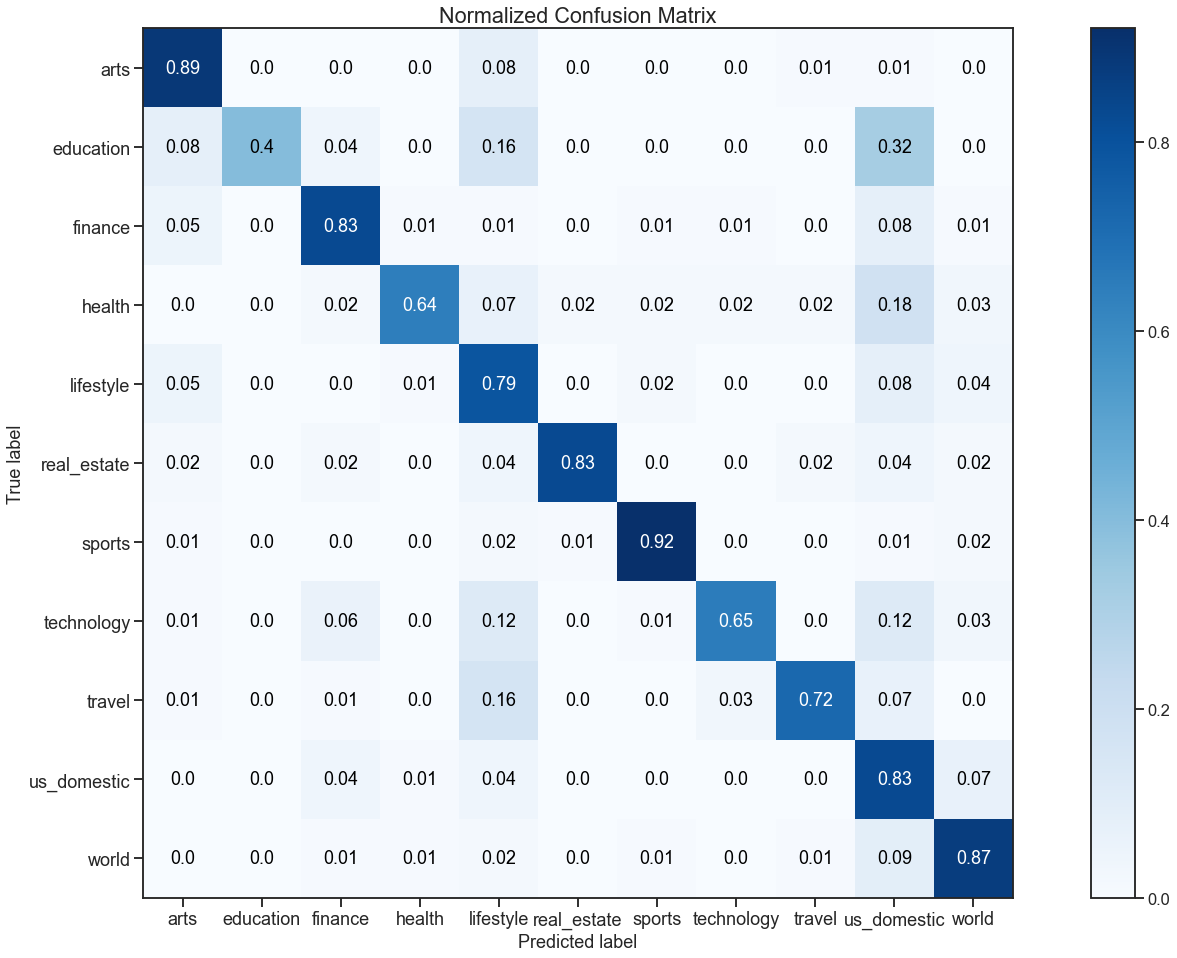

In [74]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

skplt.metrics.plot_confusion_matrix(y_test, y_pred_cv_nb, normalize=True,figsize=(28,16),
                                    title_fontsize='large',text_fontsize='medium')
plt.show()

In [76]:
print(metrics.classification_report(y_test, y_pred_cv_nb))                 

              precision    recall  f1-score   support

        arts       0.87      0.89      0.88       217
   education       1.00      0.40      0.57        25
     finance       0.80      0.83      0.82       127
      health       0.85      0.64      0.73        61
   lifestyle       0.72      0.79      0.75       245
 real_estate       0.96      0.83      0.89       160
      sports       0.96      0.92      0.94       232
  technology       0.85      0.65      0.74        69
      travel       0.85      0.72      0.78        74
 us_domestic       0.79      0.83      0.81       407
       world       0.73      0.87      0.79       160

    accuracy                           0.82      1777
   macro avg       0.85      0.76      0.79      1777
weighted avg       0.83      0.82      0.82      1777



In [75]:
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, y_pred_cv_nb, normalize=True))
print("Precision score:", sklearn.metrics.precision_score(y_test, y_pred_cv_nb, average='weighted'))
print("Recall score:", sklearn.metrics.recall_score(y_test, y_pred_cv_nb, average='weighted'))
print("f1 score:", sklearn.metrics.f1_score(y_test, y_pred_cv_nb, average='weighted'))

Accuracy score: 0.8244231851435003
Precision score: 0.8321953692495975
Recall score: 0.8244231851435003
f1 score: 0.8238495981219915


In [82]:
# Save the model for reloading in the deployed application
# Save the counter vectorizer in order to retain the vocabulary information

time = datetime.now().strftime("%Y-%m-%d")
path1 = 'nb_classifier-{}.pkl'.format(time)

path2 = 'nb_countvectoriser-{}.pkl'.format(time)
with open(path1, 'wb') as f1:
    pickle.dump(nb, f1)
    
with open(path2, 'wb') as f2:
    pickle.dump(cv, f2)

In [84]:
# Reload saved model
path1 = "nb_classifier-2020-08-16.pkl"
with open(path1, 'rb') as f:
    model = pickle.load(f)

# Check the class label of reloaded model
model.classes_

array(['arts', 'education', 'finance', 'health', 'lifestyle',
       'real_estate', 'sports', 'technology', 'travel', 'us_domestic',
       'world'], dtype='<U11')

In [85]:
# Reload saved count vectorizer
path2 = "nb_countvectoriser-2020-08-16.pkl"
with open(path2, 'rb') as f:
    trained_cv = pickle.load(f)

In [86]:
def preprocess(text):
    alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    text = alphanumeric(text)
    text = punc_lower(text)
    return text

In [87]:
def encode_text_to_vector(cv, text):
       new_cv = CountVectorizer(stop_words='english', vocabulary=cv.vocabulary_)
       text_vector = new_cv.fit_transform( [text ] )
       return text_vector

In [96]:
new_text = input("Enter the new text: \n\n")
new_text2 = preprocess(new_text)
new_text_vector = encode_text_to_vector(trained_cv, new_text2)
predicted_label = (model.predict(new_text_vector))
predicted_prob = model.predict_proba(new_text_vector)

print ("\n\n The text is predicted as <" , predicted_label , ">.")

Enter the new text: 

 "The chaotic response to the coronavirus in Brazil, where it has killed more than 105,000 people, made the country’s experience a cautionary tale that many around the world have watched with alarm.  But as the country’s caseload soared, vaccine researchers saw a unique opportunity.  With sustained widespread contagion, a deep bench of immunization experts, a robust medical manufacturing infrastructure and thousands of vaccine trial volunteers, Brazil has emerged as a potentially vital player in the global scramble to end the pandemic.  Three of the most promising and advanced vaccine studies in the world are relying on scientists and volunteers in Brazil, according to the World Health Organization’s report on the progress of vaccine research.  The embattled government hopes its citizens could be among the first in the world to be inoculated. And medical experts are imagining the possibility that Brazil could even manufacture the vaccine and export it to neighbori



 The text is predicted as < ['health'] >.


In [89]:
# Display the classes (labels) that the model can predict
model.classes_

array(['arts', 'education', 'finance', 'health', 'lifestyle',
       'real_estate', 'sports', 'technology', 'travel', 'us_domestic',
       'world'], dtype='<U11')

In [90]:
# Display probability scores associated to the predicted labels
predicted_prob 

array([[6.54864708e-67, 4.96427662e-80, 6.63576197e-41, 2.61062209e-18,
        1.22819273e-30, 5.82606390e-57, 9.18445778e-66, 4.02529655e-34,
        3.04238852e-78, 2.63059154e-14, 1.00000000e+00]])